IMAGENET-C_BF_divergences

Data directories:

In [1]:
######################### Insert_here

# Set up

In [2]:
base_dir = base_dir_path
IMAGENET_C_data = IMAGENET_C_data_path
Subcategory_IMAGENET_C_files = Subcategory_IMAGENET_C_files_path

In [3]:
real_data = real_data

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import os
from scipy import stats 
from scipy import fftpack
import cv2
import glob
import pickle
import seaborn as sns
# from math import nan, isnan
import copy

## Change parameters and rerun this section:

In [5]:
# change
category = "noise" ################# CHANGE FOR DATASET ####################
subcategory = "gaussian_noise" ################# CHANGE FOR DATASET ####################
severity = "1" ################# CHANGE FOR DATASET ####################

In [6]:
num_channels = 3 ################# CHANGE FOR DATASET ####################
gs = 3 # 3 for greyscale ################# CHANGE FOR DATASET ####################

In [7]:
FDs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/FDs/FDs_DCT_{category}_{subcategory}_{severity}.pkl"


In [8]:
KLs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/KLs_DCT_{category}_{subcategory}_{severity}.pkl"

JSs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/JSs_DCT_{category}_{subcategory}_{severity}.pkl"

Empirical setup:

In [9]:
bench_FDs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/FDs/bench_FDs_DCT.pkl"

In [10]:
########################################################### test
bench_KLs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/bench_KLs_DCT.pkl"
bench_JSs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/bench_JSs_DCT.pkl"

In [11]:
emp_bench_KLs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/emp_bench_KLs_DCT.pkl" 
emp_bench_JSs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/emp_bench_JSs_DCT.pkl"

## Utilities

In [12]:
dist_benford_law = np.zeros(9)
for d in range(1,10):
    dist_benford_law[d-1] = math.log(1 + 1/(d), 10)

In [13]:
# Define 2D DCT 
def dct2(a):
    return fftpack.dct(fftpack.dct( a, axis=0, norm='ortho' ), 
                             axis=1, norm='ortho' )

def DCT(images):
  imsize = images.shape
  DCT_input = np.zeros(imsize)

  #DCT_input = np.copy(images)
  for im_no in range(len(images)):
    im = images[im_no].reshape(images.shape[1],images.shape[2])
    imsize = im.shape
    dct = np.zeros(imsize)
    for i in np.r_[:imsize[0]:8]:
      for j in np.r_[:imsize[1]:8]:
          dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)] )
    #print(dct[10])
    DCT_input[im_no,:,:,0] = dct
  return DCT_input

def benford_law_images(input_img):
    freq_array = np.zeros(10)

    for i in range(len(input_img)):
        first_digit = int(abs(input_img[i])*255 // 
                          (10 ** (int(math.log(max(abs(input_img[i])*255, 1e-32), 10))) ))
        # print(first_digit)
        freq_array[first_digit] += 1
    
    return freq_array

In [14]:
def iterative_gradient(original_images, it):

    gradient_input = np.copy(original_images)

    for i in range(it):

        gradient_x = list()
        gradient_y = list()
        
        for i in range(len(gradient_input)):
            gradient_x.append(cv2.Sobel(gradient_input[i], cv2.CV_64F, 1, 0, ksize=1))
            gradient_y.append(cv2.Sobel(gradient_input[i], cv2.CV_64F, 0, 1, ksize=1))

        gradient_input = np.sqrt(np.square(gradient_x) + np.square(gradient_y))

    return gradient_input

# Imagenet-C calculations for specified category, subcategory, severity

## FDs

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2

When changing parameters: Change parameters in 1.1. Run 1.1

DCT

In [ ]:
next(os.walk(f'{base_dir}{IMAGENET_C_data}/{category}/{subcategory}/{severity}.'))#[1]

In [ ]:
if not os.path.exists(FDs_DCT_f): 
    FDs_DCT = []

    for class_id in range(len(next(os.walk(f'{base_dir}{IMAGENET_C_data}/{category}/{subcategory}/{severity}.'))[1])): 
        IMAGENET_CLASS = next(os.walk(f'{base_dir}{IMAGENET_C_data}/{category}/{subcategory}/{severity}.'))[1][class_id]
        ims = list()
        for file in glob.glob(f'{base_dir}{IMAGENET_C_data}/{category}/{subcategory}/{severity}/{IMAGENET_CLASS}/*.jpeg'):
            img = Image.open(file)
            img = img.convert('L') # converting to greyscale
            img = np.asarray(np.int8(img)) - 128 # centering around 0
            ims.append(img)

        ims = np.array(ims).reshape(np.array(ims).shape[0],np.array(ims).shape[1], np.array(ims).shape[2],
                                    int(num_channels/gs)) # taking greyscale so 3/3 = 1 channel
        
        # transforming using DCT
        DCT_ims = DCT(np.array(ims))
        FD_DCT = []

        for im_i in range(len(DCT_ims)):
            FD_DCT.append(benford_law_images(DCT_ims[im_i].reshape(DCT_ims.shape[1]*DCT_ims.shape[2])))

        FDs_DCT.append(FD_DCT)

In [ ]:
# save file
if not os.path.exists(FDs_DCT_f): 
    with open(FDs_DCT_f, "wb") as fp: 
        pickle.dump(FDs_DCT, fp) 

## BF Divergences

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2

When changing parameters: Change parameters in 1.1. Run 1.1

DCT

In [ ]:
# load saved file
with open(FDs_DCT_f, "rb") as fp: 
    FDs_DCT = pickle.load(fp) 

In [ ]:
if not os.path.exists(KLs_DCT_f): 
    KLs_DCT = []
    JSs_DCT = []
    
    for class_id in range(len(FDs_DCT)): 
        KL_DCT = []
        JS_DCT = []
        
        for i in range(len(FDs_DCT[class_id])):
            KL_DCT.append(stats.entropy(dist_benford_law, FDs_DCT[class_id][i][1:])) 
            JS_DCT.append(stats.entropy(dist_benford_law, FDs_DCT[class_id][i][1:]) + stats.entropy(FDs_DCT[class_id][i][1:],dist_benford_law))
        
        KLs_DCT.append(KL_DCT)
        JSs_DCT.append(JS_DCT)

In [ ]:
# save file
if not os.path.exists(KLs_DCT_f): 
    with open(KLs_DCT_f, "wb") as fp: 
        pickle.dump(KLs_DCT, fp)  

if not os.path.exists(JSs_DCT_f): 
    with open(JSs_DCT_f, "wb") as fp: 
        pickle.dump(JSs_DCT, fp) 
        

# Benchmark calculations on uncorrupted Imagenet validation data

## FDs

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2

When changing parameters: Change parameters in 1.1. Run 1.1

DCT

In [ ]:
if not os.path.exists(bench_FDs_DCT_f): 
    DCT_ims = []
    FD_DCT = []
    
    for file in glob.glob(f'{base_dir}{real_data}/*.jpeg'):
        img = Image.open(file)
        img = img.convert('L') # converting to greyscale
        img = np.asarray(np.int8(img)) - 128 # centering around 0
        
        DCT_img = DCT(img.reshape(1,img.shape[0], img.shape[1],int(num_channels/gs))) # transforming using DCT
        FD_DCT.append(benford_law_images(DCT_img.reshape(DCT_img.shape[1]*DCT_img.shape[2])))


In [ ]:
# save file
if not os.path.exists(bench_FDs_DCT_f): 
    with open(bench_FDs_DCT_f, "wb") as fp: 
        pickle.dump(FD_DCT, fp) 

## BF Divergences

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2, 3.0

When changing parameters: Change parameters in 1.1. Run 1.1

In [ ]:
# load saved file
with open(bench_FDs_DCT_f, "rb") as fp: 
    bench_FDs_DCT = pickle.load(fp) 

In [ ]:
if not os.path.exists(bench_KLs_DCT_f): 
    bench_KLs_DCT = []
    bench_JSs_DCT = []
    
    for i in range(len(bench_FDs_DCT)):
        bench_KLs_DCT.append(stats.entropy(dist_benford_law, bench_FDs_DCT[i][1:])) 
        bench_JSs_DCT.append(stats.entropy(dist_benford_law, bench_FDs_DCT[i][1:]) + stats.entropy(bench_FDs_DCT[i][1:],dist_benford_law))


In [ ]:
# save file
if not os.path.exists(bench_KLs_DCT_f): 
    with open(bench_KLs_DCT_f, "wb") as fp: 
        pickle.dump(bench_KLs_DCT, fp) 
        
if not os.path.exists(bench_JSs_DCT_f): 
    with open(bench_JSs_DCT_f, "wb") as fp: 
        pickle.dump(bench_JSs_DCT, fp) 

# Calculate empirical divergences for Imagenet-C for specified category, subcategory, severity

## Calculate empirical FD benchmark

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2

When changing parameters: Change parameters in 1.1. Run 1.1

DCT

In [ ]:
# load saved file
with open(bench_FDs_DCT_f, "rb") as fp: 
    bench_FDs_DCT = pickle.load(fp) 

In [ ]:
bench_dist = np.mean(bench_FDs_DCT,axis=0)[1:]
bench_dist = bench_dist/sum(bench_dist)

In [ ]:
bench_dist

## Empirical divergence

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2, 4.1

When changing parameters: Change parameters in 1.1. Run 1.1

In [ ]:
emp_KLs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/emp_KLs_DCT_{category}_{subcategory}_{severity}.pkl"
emp_JSs_DCT_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/emp_JSs_DCT_{category}_{subcategory}_{severity}.pkl"

DCT

In [ ]:
# load saved file
with open(FDs_DCT_f, "rb") as fp: 
    FDs_DCT = pickle.load(fp) 

In [ ]:
if not os.path.exists(emp_KLs_DCT_f): 
    KLs_DCT = []
    JSs_DCT = []
    
    for class_id in range(len(FDs_DCT)): 
        KL_DCT = []
        JS_DCT = []
        
        for i in range(len(FDs_DCT[class_id])):
            KL_DCT.append(stats.entropy(bench_dist, FDs_DCT[class_id][i][1:])) 
            JS_DCT.append(stats.entropy(bench_dist, FDs_DCT[class_id][i][1:]) + stats.entropy(FDs_DCT[class_id][i][1:], bench_dist)) 
        
        KLs_DCT.append(KL_DCT)
        JSs_DCT.append(JS_DCT)
# C:\Users\lauraa.omahony\Anaconda3\envs\First_digit_experiments\lib\site-packages\scipy\stats\_entropy.py:78: RuntimeWarning: invalid value encountered in true_divide
#   qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)

In [ ]:
# save file
if not os.path.exists(emp_KLs_DCT_f): 
    with open(emp_KLs_DCT_f, "wb") as fp: 
        pickle.dump(KLs_DCT, fp) 
      
if not os.path.exists(emp_JSs_DCT_f): 
    with open(emp_JSs_DCT_f, "wb") as fp: 
        pickle.dump(JSs_DCT, fp)   

GM

## Empirical divergence for Imagenet-C

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2, 4.1

When changing parameters: Change parameters in 1.1. Run 1.1

In [ ]:
# load saved file
with open(bench_FDs_DCT_f, "rb") as fp: 
    bench_FDs_DCT = pickle.load(fp) 

In [ ]:
if not os.path.exists(emp_bench_KLs_DCT_f): 
    emp_bench_KLs_DCT = []
    emp_bench_JSs_DCT = []
    
    for i in range(len(bench_FDs_DCT)):
        emp_bench_KLs_DCT.append(stats.entropy(bench_dist, bench_FDs_DCT[i][1:])) 
        emp_bench_JSs_DCT.append(stats.entropy(bench_dist, bench_FDs_DCT[i][1:]) + stats.entropy(bench_FDs_DCT[i][1:],bench_dist))


In [ ]:
# save file
if not os.path.exists(emp_bench_KLs_DCT_f): 
    with open(emp_bench_KLs_DCT_f, "wb") as fp: 
        pickle.dump(emp_bench_KLs_DCT, fp) 
      
if not os.path.exists(emp_bench_JSs_DCT_f): 
    with open(emp_bench_JSs_DCT_f, "wb") as fp: 
        pickle.dump(emp_bench_JSs_DCT, fp)   

# Plots and Summaries

Prerequisites:

First time: Change parameters in 1.1. Run 1.0, 1.1, 1.2

When changing parameters: Change parameters in 1.1. Run 1.1

Ensure you have all KLs_DCT_category_subcategory_severity.pkl and JSs_DCT_category_subcategory_severity.pkl files created in 2 for corrution severity levels. 

Aso need bench_KLs_DCT.pkl and bench_JSs_DCT.pkl (divergence of Imagenet-C from BF) files created in 3.2. 

## Load files for current configuration

In [173]:
corruption_levels = [1,3,5]
Imagenet_corruption_levels = ["Clean",1,3,5]

In [174]:
KLs_DCT_files = []
# KLs_GM_files = []
JSs_DCT_files = []

for lev in range(len(corruption_levels)):
    KLs_DCT_files.append(f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/KLs_DCT_{category}_{subcategory}_{corruption_levels[lev]}.pkl")
#     KLs_GM_files.append(f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/KLs_GM_{category}_{subcategory}_{corruption_levels[lev]}.pkl")
    JSs_DCT_files.append(f"{base_dir}{Subcategory_IMAGENET_C_files}/Divergences/JSs_DCT_{category}_{subcategory}_{corruption_levels[lev]}.pkl")

In [175]:
KLs_DCT_levs = []
# KLs_GM_levs = []
JSs_DCT_levs = []

# load saved files
for lev in range(len(corruption_levels)):
    with open(KLs_DCT_files[lev], "rb") as fp: 
        KLs_DCT_levs.append(pickle.load(fp))
#     with open(KLs_GM_files[lev], "rb") as fp: 
#         KLs_GM_levs.append(pickle.load(fp))
    with open(JSs_DCT_files[lev], "rb") as fp: 
        JSs_DCT_levs.append(pickle.load(fp))
        
with open(bench_KLs_DCT_f, "rb") as fp: 
    bench_KLs_DCT = pickle.load(fp)
with open(bench_JSs_DCT_f, "rb") as fp: 
    bench_JSs_DCT = pickle.load(fp)

## BF plots

In [176]:
DCT_KL_boxplot_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Figures/BF/crop/pic_KLs_DCT_{category}_{subcategory}_{corruption_levels}.png"
DCT_KL_boxplot_full_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Figures/BF/full/pic_KLs_DCT_full_{category}_{subcategory}_{corruption_levels}.png"

DCT_JS_boxplot_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Figures/BF/crop/pic_JSs_DCT_{category}_{subcategory}_{corruption_levels}.png"
DCT_JS_boxplot_full_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Figures/BF/full/pic_JSs_DCT_full_{category}_{subcategory}_{corruption_levels}.png"


In [177]:
KLs_DCT_all = []

KLs_DCT_all.append(bench_KLs_DCT)
KLs_DCT_all.append(KLs_DCT_levs[0])
KLs_DCT_all.append(KLs_DCT_levs[1])
KLs_DCT_all.append(KLs_DCT_levs[2])

JSs_DCT_all = []

JSs_DCT_all.append(bench_JSs_DCT)
JSs_DCT_all.append(JSs_DCT_levs[0])
JSs_DCT_all.append(JSs_DCT_levs[1])
JSs_DCT_all.append(JSs_DCT_levs[2])

saved file!


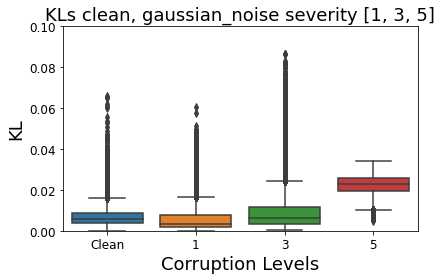

In [179]:
fig_KL = sns.boxplot(data=KLs_DCT_all)
fig_KL.set_xticklabels(Imagenet_corruption_levels)
fig_KL.tick_params(labelsize=12)
plt.xlabel('Corruption Levels', fontsize=18)
plt.ylabel('KL', fontsize=18)
plt.ylim(0, 0.1)
plt.title(label = f"KLs clean, {subcategory} severity {corruption_levels}", fontsize=18)
plt.tight_layout()

if not os.path.exists(DCT_KL_boxplot_f):
    plt.savefig(DCT_KL_boxplot_f) 
    print("saved file!")
else: 
    print("File already exists!")
    

saved file!


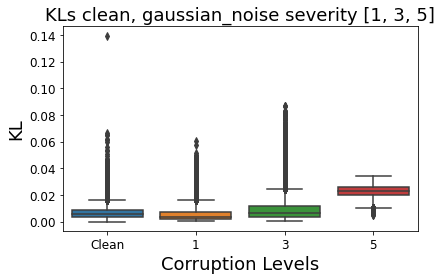

In [180]:
fig_KL = sns.boxplot(data=KLs_DCT_all)
fig_KL.set_xticklabels(Imagenet_corruption_levels)
fig_KL.tick_params(labelsize=12)
plt.xlabel('Corruption Levels', fontsize=18)
plt.ylabel('KL', fontsize=18)
plt.title(label = f"KLs clean, {subcategory} severity {corruption_levels}", fontsize=18)
plt.tight_layout()

if not os.path.exists(DCT_KL_boxplot_full_f):
    plt.savefig(DCT_KL_boxplot_full_f) 
    print("saved file!")
else: 
    print("File already exists!")
    

saved file!


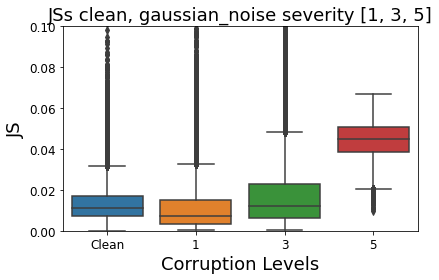

In [181]:
fig_JS = sns.boxplot(data=JSs_DCT_all)
fig_JS.set_xticklabels(Imagenet_corruption_levels)
fig_JS.tick_params(labelsize=12)
plt.xlabel('Corruption Levels', fontsize=18)
plt.ylabel('JS', fontsize=18)
plt.ylim(0, 0.1)
plt.title(label = f"JSs clean, {subcategory} severity {corruption_levels}", fontsize=18)
plt.tight_layout()

if not os.path.exists(DCT_JS_boxplot_f):
    plt.savefig(DCT_JS_boxplot_f) 
    print("saved file!")
else: 
    print("File already exists!")
    

saved file!


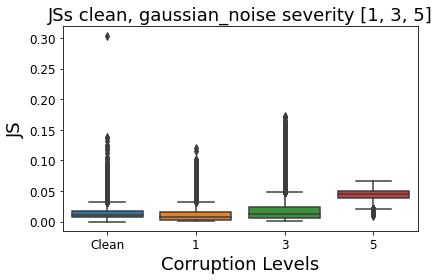

In [182]:
fig_JS = sns.boxplot(data=JSs_DCT_all)
fig_JS.set_xticklabels(Imagenet_corruption_levels)
fig_JS.tick_params(labelsize=12)
plt.xlabel('Corruption Levels', fontsize=18)
plt.ylabel('JS', fontsize=18)
# plt.ylim(0, 0.1)
plt.title(label = f"JSs clean, {subcategory} severity {corruption_levels}", fontsize=18)
plt.tight_layout()

if not os.path.exists(DCT_JS_boxplot_full_f):
    plt.savefig(DCT_JS_boxplot_full_f) 
    print("saved file!")
else: 
    print("File already exists!")
    

## Divergence differences

In [121]:
DCT_KL_boxplot_1_3_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Figures/BF/diff_KLs_DCT_{category}_{subcategory}.png"
DCT_JS_boxplot_1_3_f = f"{base_dir}{Subcategory_IMAGENET_C_files}/Figures/BF/diff_JSs_DCT_{category}_{subcategory}.png"


In [122]:
KLs_diff = []
JSs_diff = []

KLs_DCT_1_3 = np.array(KLs_DCT_levs[1]) - np.array(KLs_DCT_levs[0])
KLs_DCT_1_5 = np.array(KLs_DCT_levs[2]) - np.array(KLs_DCT_levs[0])

KLs_diff.append(KLs_DCT_1_3.tolist())
KLs_diff.append(KLs_DCT_1_3.tolist())

JSs_DCT_1_3 = np.array(JSs_DCT_levs[1]) - np.array(JSs_DCT_levs[0])
JSs_DCT_1_5 = np.array(JSs_DCT_levs[2]) - np.array(JSs_DCT_levs[0])

JSs_diff.append(JSs_DCT_1_3.tolist())
JSs_diff.append(JSs_DCT_1_3.tolist())

saved file!


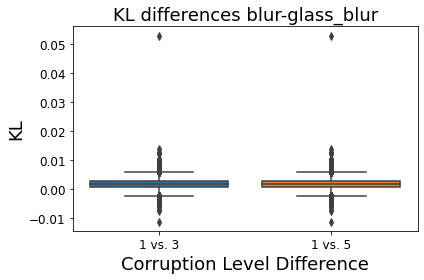

In [123]:
fig = sns.boxplot(data=KLs_diff)
fig.set_xticklabels(["1 vs. 3","1 vs. 5"])
fig.tick_params(labelsize=12)
plt.xlabel('Corruption Level Difference', fontsize=18)
plt.ylabel('KL', fontsize=18)
# plt.ylim(0, 0.1)
plt.title(label = f"KL differences {category}-{subcategory}", fontsize=18)
plt.tight_layout()

if not os.path.exists(DCT_KL_boxplot_1_3_f):
    plt.savefig(DCT_KL_boxplot_1_3_f) 
    print("saved file!")
else: 
    print("File already exists!")


saved file!


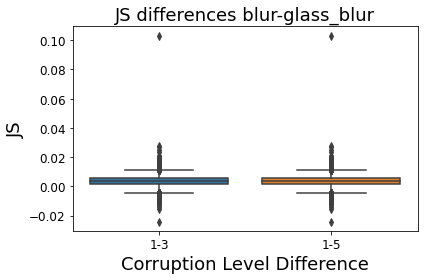

In [124]:
fig = sns.boxplot(data=JSs_diff)
fig.set_xticklabels(["1-3","1-5"])
fig.tick_params(labelsize=12)
plt.xlabel('Corruption Level Difference', fontsize=18)
plt.ylabel('JS', fontsize=18)
# plt.ylim(0, 0.1)
plt.title(label = f"JS differences {category}-{subcategory}", fontsize=18)
plt.tight_layout()

if not os.path.exists(DCT_JS_boxplot_1_3_f):
    plt.savefig(DCT_JS_boxplot_1_3_f) 
    print("saved file!")
else: 
    print("File already exists!")


## Process to get rid of inf values

Get rid of inf values

Benchmark first: 

In [ ]:
bench_KLs_DCT1 = copy.deepcopy(bench_KLs_DCT)
bench_JSs_DCT1 = copy.deepcopy(bench_JSs_DCT)

In [ ]:
############################################## test
for i in reversed(range(len(bench_KLs_DCT1))): 
    if np.isinf(bench_KLs_DCT1[i]):
        bench_KLs_DCT1 = np.array(np.delete(bench_KLs_DCT1, i, axis=0)).tolist()
for i in reversed(range(len(bench_JSs_DCT1))): 
    if np.isinf(bench_JSs_DCT1[i]):
        bench_JSs_DCT1 = np.array(np.delete(bench_JSs_DCT1, i, axis=0)).tolist()            


Now corrupted images:

In [ ]:
KLs_DCT_levs1 = copy.deepcopy(KLs_DCT_levs)
# KLs_GM_levs1 = copy.deepcopy(KLs_GM_levs)
JSs_DCT_levs1 = copy.deepcopy(JSs_DCT_levs)

In [ ]:
for lev in range(len(corruption_levels)):
    for cl in range(len(KLs_DCT_levs1[lev])):
        for i in reversed(range(len(KLs_DCT_levs1[lev][cl]))): 
            if np.isinf(KLs_DCT_levs1[lev][cl][i]):
                KLs_DCT_levs1[lev][cl] = np.array(np.delete(KLs_DCT_levs1[lev][cl], i, axis=0)).tolist()
#             if np.isinf(KLs_GM_levs1[lev][cl][i]):
#                 KLs_GM_levs1[lev][cl] = np.array(np.delete(KLs_GM_levs1[lev][cl], i, axis=0)).tolist()
#         for i in reversed(range(len(KLs_GM_levs1[lev][cl]))): 
#             if math.isnan(KLs_GM_levs1[lev][cl][i]):
#                 KLs_GM_levs1[lev][cl] = np.array(np.delete(KLs_GM_levs1[lev][cl], i, axis=0)).tolist()
        
        for i in reversed(range(len(JSs_DCT_levs1[lev][cl]))): 
                if np.isinf(JSs_DCT_levs1[lev][cl][i]):
                    JSs_DCT_levs1[lev][cl] = np.array(np.delete(JSs_DCT_levs1[lev][cl], i, axis=0)).tolist()            


## Calculate means

In [ ]:
#########################################################################

In [ ]:
bench_KLs_DCT1_mean = np.mean(bench_KLs_DCT1)
bench_JSs_DCT1_mean = np.mean(bench_JSs_DCT1)

In [ ]:
KLs_DCT_levs1_mean = []
# KLs_GM_levs1_mean = []
JSs_DCT_levs1_mean = []
for lev in range(len(corruption_levels)):
    temp_DCT_KL = []
#     temp_GM = []
    temp_DCT_JS = []
    for cl in range(len(KLs_DCT_levs1[lev])):
        temp_DCT_KL.append(np.mean(KLs_DCT_levs1[lev][cl]))
#         temp_GM.append(np.mean(KLs_GM_levs1[lev][cl]))
        temp_DCT_JS.append(np.mean(JSs_DCT_levs1[lev][cl]))
    
    KLs_DCT_levs1_mean.append(temp_DCT_KL)
#     KLs_GM_levs1_mean.append(temp_GM)
    JSs_DCT_levs1_mean.append(temp_DCT_JS)

In [ ]:
# RW scatterplot
plt.figure(figsize=(25, 5))
for lev in range(len(corruption_levels)):
    for class_id in range(5): # len(KLs_DCT)): KLs_DCT_levs
        plt.subplot(1, 5, class_id+1)
        plt.scatter(range(len(KLs_DCT_levs[lev][class_id])),KLs_DCT_levs[lev][class_id])

# Plots of images, transformed images and FD distributions

Benford's Law

$$ p(d) = log_{10}(1+\frac{1}{d}), d = 1,2,...,9 $$

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(range(1,10), dist_benford_law, color='k')
plt.xticks(range(1,10))
plt.title("Benford's Law", fontsize=15)
plt.xlabel("First digit", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
plt.bar(range(1,10), bench_dist, color='k')
plt.xticks(range(1,10))
plt.title("Empirical DCT", fontsize=15)
plt.xlabel("First digit", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
# plt.subplot(1,2,2)
# plt.bar(range(1,10), emp_GM, color='k')
# plt.xticks(range(1,10))
# plt.title("Empirical GM", fontsize=15)
# plt.xlabel("First digit", fontsize=12)
# plt.ylabel("Frequency", fontsize=12)
# plt.show()

In [ ]:
m=5

In [ ]:
ims = list()
imgs = list()
DCT_ims = list()
GM_ims = list()
FDs_DCT_display = []
FDs_GM_display = []

for class_id in range(m): 
    # first 5 classes
    IMAGENET_CLASS = next(os.walk(f'{base_dir}{IMAGENET_C_data}/{category}/{subcategory}/{severity}.'))[1][class_id]
    
    # first file from each class
    file = glob.glob(f'{base_dir}{IMAGENET_C_data}/{category}/{subcategory}/{severity}/{IMAGENET_CLASS}/*.jpeg')[0]
    im = Image.open(file)
    ims.append(im)
    img = im.convert('L') # converting to greyscale
    img = np.asarray(np.int8(img)) - 128 # centering around 0
    imgs.append(img)

    img = np.array(img).reshape(1,np.array(img).shape[0], np.array(img).shape[1],
                                int(num_channels/gs)) # taking greyscale so 3/3 = 1 channel

    # transforming using DCT or GM
    DCT_ims.append(DCT(np.array(img)))
    GM_ims.append(iterative_gradient(np.array(img),1))

for im_i in range(len(DCT_ims)):
    FDs_DCT_display.append(benford_law_images(DCT_ims[im_i].reshape(DCT_ims[im_i].shape[1]*DCT_ims[im_i].shape[2])))
    FDs_GM_display.append(benford_law_images(GM_ims[im_i].reshape(GM_ims[im_i].shape[1]*GM_ims[im_i].shape[2])))


In [ ]:
m = 5
plt.figure(figsize=(25, 25))
for i in range(m):
    im = ims[i] 
    plt.subplot(5, m, i+1)
    plt.imshow(im)
    plt.subplot(5, m, i+1+5)
    plt.imshow(DCT_ims[i].reshape(DCT_ims[i].shape[1],DCT_ims[i].shape[2],DCT_ims[i].shape[3]),cmap='gray',vmax = np.max(DCT_ims)*0.01,vmin = 0)
    plt.subplot(5, m, i+1+10)
    plt.bar(range(1,10), FDs_DCT_display[i][1:], color='k')
    plt.subplot(5, m, i+1+15)
    plt.imshow(GM_ims[i].reshape(DCT_ims[i].shape[1],DCT_ims[i].shape[2]),cmap='gray')
    plt.subplot(5, m, i+1+20)
    plt.bar(range(1,10), FDs_GM_display[i][1:])
    plt.axis('off')